# Numerical Modeling, Skoltech, Term 3, 2023

## Problem Set 3

### Spectral Methods

Consider a problem of solving
\\[
\begin{align*}
-\Delta u &= f, \\
u|_\Gamma &= 0.
\end{align*}
\\]
by a spectral method, where $\Omega = [0,1]^2$ is a unit square and $\Gamma=\partial\Omega$.

In a spectral method you will be working with a representation of the solution in the form
$$
u(x,y) = \sum_{i=1}^N \sum_{j=1}^N \hat{u}_{i,j} \sin(\pi i x) \sin(\pi j y),
$$
where $\hat{u}^N$ is just an $N\times N$ array.

Knowing $u(x,y)$, it is often practically not possible to compute $\hat{u}_{i,j}$ exactly. Hence one needs to use the [Discrete Sine Transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dst.html) (DST).
The python's <tt>dst</tt> computes a one-dimensional DST, but we need a two-dimensional (2D) DST, which we compute in the following way:
    
* Compute values $u(x,y)$ for $N^2$ points inside the domain $(x,y) = (h k, h \ell)$, $1\leq k,\ell \leq N$, $h = 1/(N+1)$.

* Apply <tt>dst</tt> to each line in this array. This way you will be computing a "partial" 2D DST
$$
u(x,y) = \sum_{j=1}^N \tilde{u}_{j}(x) \sin(\pi j y),
$$

* Apply <tt>dst</tt> to each column in the resulting array. This way you will be computing a full 2D DST.
<br><br>


### Problem 1 (Spectral Methods) (80pt)

* Part (a)
    - Take $u^0(x,y) = \sin(\pi x) \sin(\pi y)$ and compute $f = -\Delta u^0$. 
    - **(8pt)** Calculate, explicitly, the coefficients $\hat{f}_{i,j}$ in 
    $$
    f(x,y) = \sum_{i=1}^N \sum_{j=1}^N \hat{f}_{i,j} \sin(\pi i x) \sin(\pi j y).
    $$
    Then, using values of $f$ at $N^2$ points, calculate the coefficients $\hat{f}^{N}_{i,j}$ by the procedure outlined above.
    (Here $\hat{f}$ is an "infinite array" that you will compute explicitly, while $\hat{f}^N$ will be an NxN array that you will compute using python.)
    Compare $\hat{f}$ and $\hat{f}^N$.
    - In this case, obviously, a solution to the problem is $u=u_0$, but let us now pretend we do not know it.

    - **(8pt)** Compute the coefficients $\hat{u}^N$ from $\hat{f}^N$ found in part (a).

    - **(8pt)** We will estimate the error between the two solutions in the following way. We will take $N^2$ points in our domain, of the form $(h k, h \ell)$, same as before. We will then be interested in
    $$
    {\rm err}_N = \max_{1\leq k,\ell\leq N} |u^N(h k, h \ell) - u^0(h k, h \ell)|
    $$
    which we call an error of the solution. Calculate the error of your solution for a number of values of $N$. Explain your results

* Part (b)
    - Let us now take something a little more complicated,
    $$
    u^0(x,y) = \sin(\pi x^2) \sin(\pi y^2),
    \qquad\text{and}\qquad
    f = -\Delta u_0,
    $$
    - You cannot compute the coefficients $\hat{f}$ explicitly, so you'll have to live with only $\hat{f}^N$.
    - **(8pt)** Compute $\hat{u}^N$, the error ${\rm err}_N$, and report the error for different values of $N$. Would you say the error decays fast as $N$ increases?
    - Suppose that the spectral method has an order of convergence, in other words the error behaves like ${\rm err}_N = C N^{-\rm ord}$ and you need to find ${\rm ord}$.
        -  **(8pt)** Derive the formula
        $$
        {\rm ord}_N = \frac{\ln({\rm err}_N)-\ln({\rm err}_{2N})}{\ln(2)}
        $$
        -  **(8pt)** Hence compute ${\rm ord}_N$ for $N=1,\ldots,20$ and comment on your results. (You should start with taking each value of $N$ between 1 and 20 to understand the behavior, but you don't need to present all these numbers in your report, as long as you can illustrate the right behavior.)

* Part (c)
    - Let us now play a "fair game": take
    $$
    f(x,y) = 1.
    $$
    We then do not know the solution.
    - Use your code from part (b) to compute $\hat{f}^N$, and $\hat{u}^N$.
    - **(8pt)** Instead of the exact error we have to use the error estimate
    $$
    {\rm errest}_N = \max_{1\leq k,\ell\leq N} |u^N(h k, h \ell) - u^{2N+1}(h k, h \ell)|
    $$
    (Why did we take $2N+1$ instead $2N$?)
    Report the values of ${\rm errest}_N$ for a sequence of values of $N$.
    
    -  **(8pt)** Hence compute ${\rm errest}_N$ for a sequence of $N$ and comment on your results.
    -  **(8pt)** Finally, using the same formula (but with ${\rm errest}$),
    $$
    {\rm ord}_N = \frac{\ln({\rm errest}_N)-\ln({\rm errest}_{2N})}{\ln(2)}
    $$
    compute ${\rm ord}_N$ for a squence of values of $N$. Comment on your results. 
*  **(8pt)** Compare the behavior for ${\rm err}$, ${\rm errest}$, and ${\rm ord}$ for parts (b) and (c). What is the main reason for the qualitative difference in the speed of convergence?

### Problem 1 (Spectral Methods) (80pt)

* Part (a)
    - Take $u^0(x,y) = \sin(\pi x) \sin(\pi y)$ and compute $f = -\Delta u^0$. 



$$ f = 2\pi^2sin(\pi x)sin(\pi y)$$

- **(8pt)** Calculate, explicitly, the coefficients $\hat{f}_{i,j}$ in 
    $$
    f(x,y) = \sum_{i=1}^N \sum_{j=1}^N \hat{f}_{i,j} \sin(\pi i x) \sin(\pi j y).
    $$
    Then, using values of $f$ at $N^2$ points, calculate the coefficients $\hat{f}^{N}_{i,j}$ by the procedure outlined above.
    (Here $\hat{f}$ is an "infinite array" that you will compute explicitly, while $\hat{f}^N$ will be an NxN array that you will compute using python.)
    Compare $\hat{f}$ and $\hat{f}^N$.

$$\hat{f}_{1,1} = 2\pi^2, \quad \hat{f}_{i,j} = 0 \quad \text{for } (i, j) \neq (1,1)$$

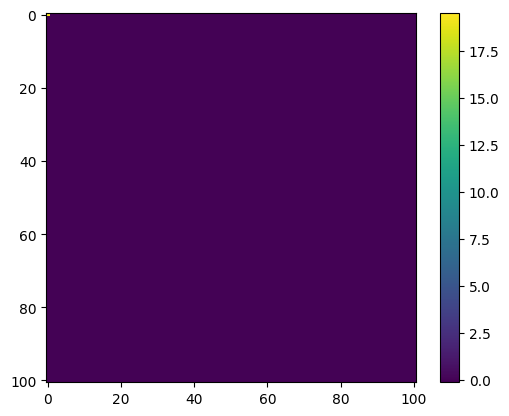

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

N = 101
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)

X, Y = np.meshgrid(x,y)
f = 2*np.pi**2*np.sin(np.pi*X)*np.sin(np.pi*Y)
u0 = np.sin(np.pi*X)*np.sin(np.pi*Y)

fN_coef = np.zeros((N,N))
for i in range(N):
    fN_coef[i] = sp.fft.dst(f[i])/N

for i in range(N):
    fN_coef[:,i] = sp.fft.dst(fN_coef[:,i])/N

plt.imshow(fN_coef)
plt.colorbar()

In [22]:
print(fN_coef[0, :])
print(fN_coef[:, 0])

[ 1.95416484e+01 -5.01095819e-16 -1.47713825e-01 -1.15791059e-16
 -8.19785445e-02 -2.64785814e-16 -5.74165042e-02 -1.62915605e-16
 -4.43425423e-02 -8.03718880e-17 -3.61863391e-02 -2.34773030e-16
 -3.06047559e-02  8.74086040e-17 -2.65441461e-02 -8.22123435e-17
 -2.34584099e-02 -5.43188768e-16 -2.10355812e-02  5.34376838e-17
 -1.90842689e-02 -1.85790660e-16 -1.74804473e-02  3.46997015e-16
 -1.61401761e-02  3.17290872e-16 -1.50046001e-02 -2.06711005e-16
 -1.40312223e-02 -1.16070588e-16 -1.31885873e-02  1.83109418e-16
 -1.24529132e-02 -1.43381704e-17 -1.18058865e-02  3.59190076e-16
 -1.12331769e-02 -4.83988347e-16 -1.07234115e-02  2.78176221e-16
 -1.02674507e-02 -1.60046273e-16 -9.85786742e-03 -2.97307926e-16
 -9.48856527e-03  5.23189368e-16 -9.15449516e-03 -1.03865027e-16
 -8.85144121e-03 -5.26302046e-17 -8.57585735e-03 -2.01270265e-16
 -8.32474104e-03  5.63894025e-17 -8.09553467e-03 -2.83759068e-16
 -7.88604776e-03 -1.70397596e-16 -7.69439512e-03  3.67219182e-16
 -7.51894715e-03  1.10133

Let's compare $\hat{f}$ and $\hat{f}^N$. As was shown above $\hat{f}_{1,1} = 2\pi^2, \quad \hat{f}_{i,j} = 0 \quad \text{for } (i, j) \neq (1,1)$.  $\hat{f}^N_{1,1}$ is on the order of $\pi^2$ but other elements aren't zero. $\hat{f}^N_{1,k}$ and $\hat{f}^N_{k,1}$ are on the order of $10^{-1} - 10^{-3}$, $k = 2m + 1 \quad \text{for } m = 1 .. (N-1)/2$

- **(8pt)** Compute the coefficients $\hat{u}^N$ from $\hat{f}^N$ found in part (a).

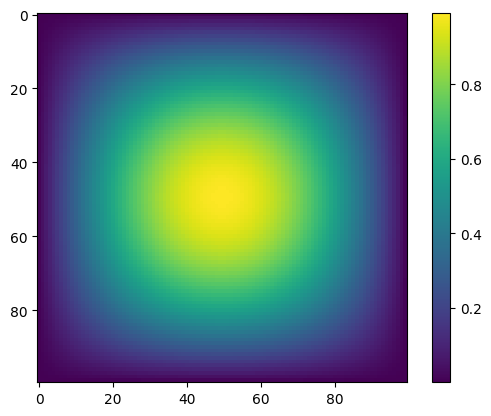

In [23]:
def solve(N):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    
    X, Y = np.meshgrid(x,y)
    f = 2*np.pi**2*np.sin(np.pi*X)*np.sin(np.pi*Y)

    fN_coef = np.empty((N,N))
    for i in range(N):
        fN_coef[i] = sp.fft.dst(f[i])
    
    for i in range(N):
        fN_coef[:,i] = sp.fft.dst(fN_coef[:,i])

    uN_coef = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            uN_coef[i,j] = fN_coef[i,j]/np.pi**2/((i+1)**2 + (j+1)**2)

    uN = np.empty((N,N))
    for i in range(N):
        uN[i] = sp.fft.idst(uN_coef[i])
    
    for i in range(N):
        uN[:,i] = sp.fft.idst(uN[:,i])

    u0 = np.sin(np.pi*X)*np.sin(np.pi*Y)

    return uN, u0

u, u0 = solve(100)

plt.imshow(u)
plt.colorbar()

- **(8pt)** We will estimate the error between the two solutions in the following way. We will take $N^2$ points in our domain, of the form $(h k, h \ell)$, same as before. We will then be interested in
    $$
    {\rm err}_N = \max_{1\leq k,\ell\leq N} |u^N(h k, h \ell) - u^0(h k, h \ell)|
    $$
    which we call an error of the solution. Calculate the error of your solution for a number of values of $N$. Explain your results

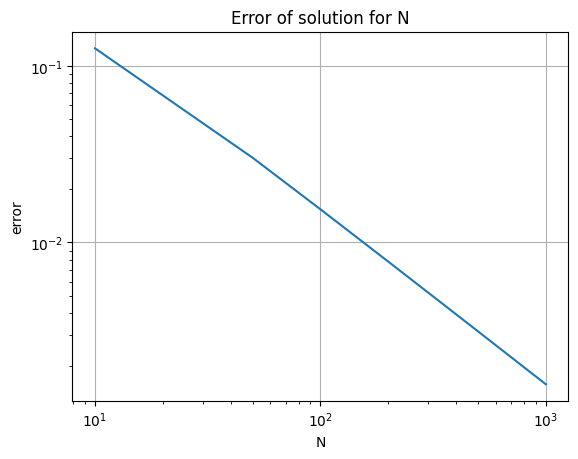

In [27]:
def error(a, b):
    return np.abs(a - b).max()

Ns = [10,50,100,200,300,500,1000]
errors = np.zeros(len(Ns))
for i,N in enumerate(Ns):
    u, u0 = solve(N)
    errors[i] = error(u, u0)
    
plt.plot(Ns, errors)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('error')
plt.title('Error of solution for N')
plt.grid()

* Part (b)
    - Let us now take something a little more complicated,
    $$
    u^0(x,y) = \sin(\pi x^2) \sin(\pi y^2),
    \qquad\text{and}\qquad
    f = -\Delta u_0,
    $$
    - You cannot compute the coefficients $\hat{f}$ explicitly, so you'll have to live with only $\hat{f}^N$.
    - **(8pt)** Compute $\hat{u}^N$, the error ${\rm err}_N$, and report the error for different values of $N$. Would you say the error decays fast as $N$ increases?
   

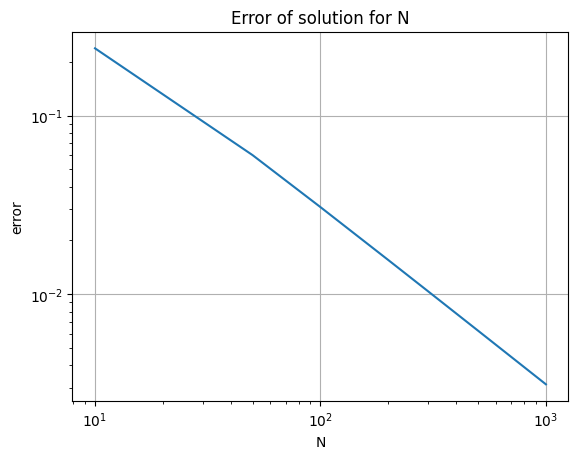

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def solve2(N):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    
    X, Y = np.meshgrid(x,y)

    u0 = np.sin(np.pi*X**2)*np.sin(np.pi*Y**2)
    f = 2*np.pi*(np.cos(np.pi*Y**2)*np.sin(np.pi*X**2) + (np.cos(np.pi*X**2) - 2*np.pi*(X**2+Y**2)*np.sin(np.pi*X**2))*np.sin(np.pi*Y**2))

    fN_coef = np.empty((N,N))
    for i in range(N):
        fN_coef[i] = sp.fft.dst(f[i])
    
    for i in range(N):
        fN_coef[:,i] = sp.fft.dst(fN_coef[:,i])

    uN_coef = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            uN_coef[i,j] = -fN_coef[i,j]/np.pi**2/((i+1)**2 + (j+1)**2)

    uN = np.empty((N,N))
    for i in range(N):
        uN[i] = sp.fft.idst(uN_coef[i])
    
    for i in range(N):
        uN[:,i] = sp.fft.idst(uN[:,i])

    return uN, u0

Ns = [10,50,100,200,300,500,1000]
errors = np.zeros(len(Ns))
for i,N in enumerate(Ns):
    u, u0 = solve2(N)
    errors[i] = error(u, u0)

plt.plot(Ns, errors)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('error')
plt.title('Error of solution for N')
plt.grid()

I would say the error decays exponentially as $N$ increases and almost as fast as in previous example.

 - Suppose that the spectral method has an order of convergence, in other words the error behaves like ${\rm err}_N = C N^{-\rm ord}$ and you need to find ${\rm ord}$.
        -  **(8pt)** Derive the formula
        $$
        {\rm ord}_N = \frac{\ln({\rm err}_N)-\ln({\rm err}_{2N})}{\ln(2)}
        $$


$$\ln(\rm err_N) = \ln(C) -\rm ord \ln(N)$$

$$\ln(\rm err_{2N}) = \ln(C) -\rm ord (\ln(N) + \ln(2))$$

Therefore, $$\ln(\rm err_N) - \ln(\rm err_{2N}) = \rm ord \ln(2)$$

 -  **(8pt)** Hence compute ${\rm ord}_N$ for $N=1,\ldots,20$ and comment on your results. (You should start with taking each value of $N$ between 1 and 20 to understand the behavior, but you don't need to present all these numbers in your report, as long as you can illustrate the right behavior.)

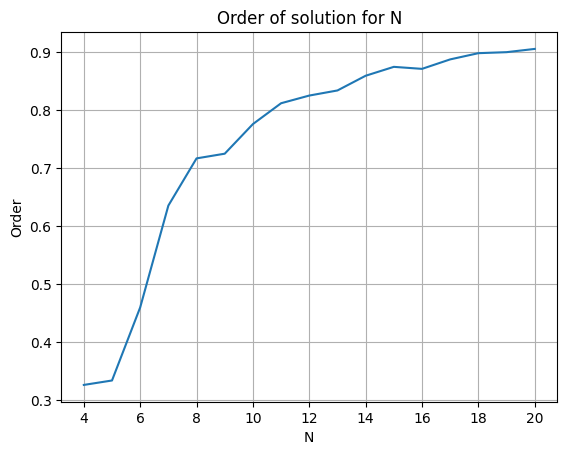

In [81]:
def ord(N):
    u, u0 = solve2(N)
    u2, u02 = solve2(2*N)
    err = error(u,u0)
    err2 = error(u2, u02)
    return (np.log(err) - np.log(err2))/np.log(2)

Ns = np.linspace(4,20,17).astype(int)
ords = np.zeros(len(Ns))
for i,N in enumerate(Ns):
    ords[i] = ord(N)

plt.plot(Ns, ords)
plt.xlabel('N')
plt.ylabel('Order')
plt.title('Order of solution for N')
plt.grid()

 ${\rm ord}_N$ for $N=1,\ldots,20$ lightly increases. If we'll compute  ${\rm ord}_N$ for big values of $N$, we'll see that ${\rm ord}_N$ approaches $1$.

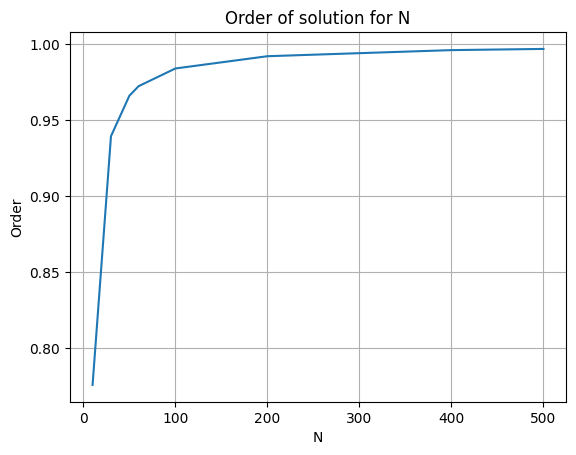

In [44]:
Ns = [10,30,50,60,100,200,400,500]
ords = np.zeros(len(Ns))
for i,N in enumerate(Ns):
    ords[i] = ord(N)

plt.plot(Ns, ords)
plt.xlabel('N')
plt.ylabel('Order')
plt.title('Order of solution for N')
plt.grid()

* Part (c)
    - Let us now play a "fair game": take
    $$
    f(x,y) = 1.
    $$
    We then do not know the solution.
    - Use your code from part (b) to compute $\hat{f}^N$, and $\hat{u}^N$.
    - **(8pt)** Instead of the exact error we have to use the error estimate
    $$
    {\rm errest}_N = \max_{1\leq k,\ell\leq N} |u^N(h k, h \ell) - u^{2N+1}(h k, h \ell)|
    $$
    (Why did we take $2N+1$ instead $2N$?)
    Report the values of ${\rm errest}_N$ for a sequence of values of $N$.
    
    -  **(8pt)** Hence compute ${\rm errest}_N$ for a sequence of $N$ and comment on your results.

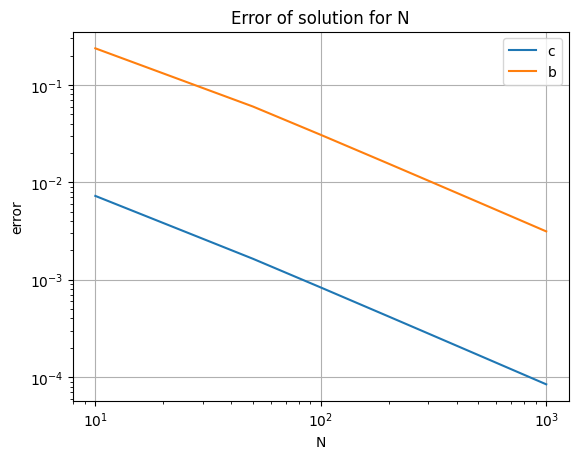

In [76]:
def solve3(N):
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    
    X, Y = np.meshgrid(x,y)

    u0 = np.sin(np.pi*X**2)*np.sin(np.pi*Y**2)
    f = np.ones((N, N))

    fN_coef = np.empty((N,N))
    for i in range(N):
        fN_coef[i] = sp.fft.dst(f[i])
    
    for i in range(N):
        fN_coef[:,i] = sp.fft.dst(fN_coef[:,i])

    uN_coef = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            uN_coef[i,j] = -fN_coef[i,j]/np.pi**2/((i+1)**2 + (j+1)**2)

    uN = np.empty((N,N))
    for i in range(N):
        uN[i] = sp.fft.idst(uN_coef[i])
    
    for i in range(N):
        uN[:,i] = sp.fft.idst(uN[:,i])

    return uN

def errest(N):
    u = solve3(N)
    u2 = solve3(2*N - 1)
    return np.abs(u - u2[::2, ::2]).max()

Ns = np.array([10,50,100,200,300,500, 1000]).astype(int)
errors_2 = np.zeros(len(Ns))
errors_1 = np.zeros(len(Ns))
for i,N in enumerate(Ns):
    u, u0 = solve2(N)
    errors_1[i] = error(u, u0)
    errors_2[i] = errest(N)
    

plt.plot(Ns, errors_2, label = 'c')
plt.plot(Ns, errors_1, label = 'b')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('error')
plt.title('Error of solution for N')
plt.grid()

**(8pt)** Finally, using the same formula (but with ${\rm errest}$),
    $$
    {\rm ord}_N = \frac{\ln({\rm errest}_N)-\ln({\rm errest}_{2N})}{\ln(2)}
    $$
    compute ${\rm ord}_N$ for a squence of values of $N$. Comment on your results. 
*  **(8pt)** Compare the behavior for ${\rm err}$, ${\rm errest}$, and ${\rm ord}$ for parts (b) and (c). What is the main reason for the qualitative difference in the speed of convergence?

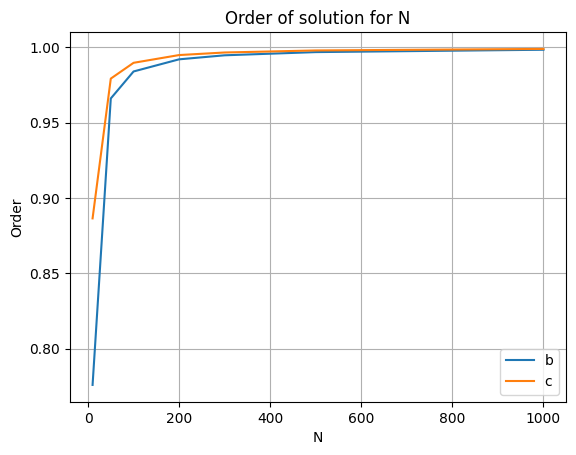

In [82]:
def ord_2(N):
    e1 = errest(N)
    e2 = errest(2*N)
    return (np.log(e1) - np.log(e2))/np.log(2)

Ns = np.array([10,50,100,200,300,500, 1000]).astype(int)
ords_2 = np.zeros(len(Ns))
ords_1 = np.zeros(len(Ns))
for i,N in enumerate(Ns):
    ords_1[i] = ord(N)
    ords_2[i] = ord_2(N)

plt.plot(Ns, ords_1, label = 'b')
plt.plot(Ns, ords_2, label = 'c')
plt.legend()
plt.xlabel('N')
plt.ylabel('Order')
plt.title('Order of solution for N')
plt.grid()

The speed of convergence is higher for the part (c). In part (b) we check how our solution converges to exact solution and in part (c) we check how the solution differs from the solution with denser grid.

### Problem 2 (Adaptivity) (20 pts)

Complete the adaptive FEM code that solves the Poisson equations form the lecture. Use [this notebook](Seminar_3_refine_mesh.ipynb)
The notebook implements the following, suboptimal error estimator:
$$ \begin{align*} \|\nabla (u_h-u)\|^2 &\leq~~ С \sum_T h_T^2 \|f\| _{L^2}^2 \end{align*}.$$

* (a) implement the following estimator `simple_2_estimator`:
$$ \begin{align*} \|\nabla (u_h-u)\|^2 &\leq~~ С \sum _{\gamma} h _{\gamma} \big\|[\nabla u _h] _{\gamma} \big\|_{L^2(\gamma)}^2 \end{align*}.$$

* (b) modify the function `good_estimator` and hence implement the right estimator: $$ \begin{align*} \|\nabla (u_h-u)\|^2 &\leq~~ С \sum_T h_T^2 \|f\| _{L^2}^2 + С \sum _{\gamma} h _{\gamma} \big\|[\nabla u _h] _{\gamma} \big\|_{L^2(\gamma)}^2 \end{align*}.$$ <!-- You can refer to the [notebook](https://github.com/MakaEdgar/NumModeling_Seminars/blob/main/Seminar_3_refine_mesh.ipynb) presented at the adaptivity lecture. -->

* (c) compare the efficiency of all the three estimators and comment which one(s) is/are best.


Please chech the file named "PS3_Pr2_code_demeshko.ipynb".